In [ ]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

Funciones de carga y preparación de datos

In [ ]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

# Ejercicio


En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Específicamente, se utilizarán los datos textuales de la subtarea 1, centrada en la clasificación de textos. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Por si fuera de tu interés, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. También hemos visto como incorporar características adicionales utilizando el sentimiento de los documentos. Para este ejercicio sois libres de utilizar la estrategia de vectorización que queráis, pero:
  -	Si decidís utilizar TF-IDF será necesarios que incorporéis a modelo características adicionales de sentimiento utilizando recursos adicionales (como por ejemplo la librería TextBlob). 
  -	Si optáis por representar el texto mediante embeddings, dado que en clase no se profundizado sobre el tema no será necesario incorporar esas características adicionales. Si decidís esta segunda opción, podéis utilizar los embeddings en español que vimos en clase

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


## 0. Imports


In [ ]:
!wget https://github.com/luisgasco/ntic_master_datos/raw/main/datasets/datos_twitter_master.tsv
!pip install emoji_extractor
!pip install emoji

# Download emoji sentiment
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip

!pip install spacy
!pip install textacy
!pip install nltk
!pip install wordcloud
!pip install collections
!pip install unidecode
!pip install imblearn

!python -m spacy download es_core_news_lg
!python -m spacy download es_core_news_md
!python -m spacy download es_core_news_sm

In [ ]:
import numpy as np
import pandas as pd
import re
from collections import Counter

# Visualización
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Emojis
from emoji_extractor.extract import Extractor

# Preprocesado
import spacy
import es_core_news_md
import textacy
from spacy import displacy
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.tokenize import sent_tokenize
# from nltk.util import ngrams
import string
from unidecode import unidecode

# Vectorización
from sklearn.feature_extraction.text import TfidfVectorizer

# Caracts adicionales
import scipy as sp
from sklearn.preprocessing import MinMaxScaler

# Modelos a probar
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Model selection
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score #, cross_validate
from sklearn.model_selection import GridSearchCV #, RandomizedSearchCV

# Técnicas de evaluación
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

# Desactivar los warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

**IMPORTANTE: lo he llamado 'dataset' en lugar de 'datos_ejercicio' por comodidad a la hora de escribir el código**

In [104]:
profner_path = "./profner/"
dataset = get_profner_data(profner_path) # lo he llamada dataset en lugar de datos_ejercicio

In [ ]:
dataset.head(4)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train


Tenemos la columna con los tweets, la col con la label (0 y 1), y set, que separa el dataset en train y test

## 2. Análisis exploratorio

In [ ]:
# número de documentos
print("El corpus contiene {} tweets".format(len(dataset)))

El corpus contiene 8000 tweets


In [ ]:
# comprobar train-test split 75% 25%
dataset.set.value_counts()

train    6000
valid    2000
Name: set, dtype: int64

In [ ]:
# veamos el reparto de labels entre los conjuntos train y test
dataset.groupby(['label', 'set']).size().reset_index(name='count')

# observar que los datos están desbalanceados

,label,set,count
0,0,train,4607
1,0,valid,1523
2,1,train,1393
3,1,valid,477


0    6130
1    1870
Name: label, dtype: int64


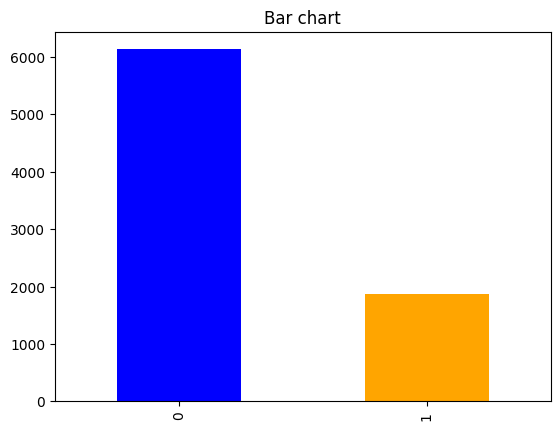

In [ ]:
print(dataset['label'].value_counts())

# histograma de label
ax, fig = plt.subplots()
etiquetas = dataset.label.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

In [ ]:
# comprobar que no haya NAs
print("Hay {} NAs en los tweets y {} NAs las etiquetas en los datos".format(np.sum(dataset.isnull())[2],
                                                                            np.sum(dataset.isnull())[3]))

Hay 0 NAs en los tweets y 0 NAs las etiquetas en los datos


In [ ]:
# Distribución de la longitud de los tweet en caracteres
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))

dataset.head()

,tweet_id,tweet_text,label,set,char_len
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,87
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,90
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,95
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,225
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,138


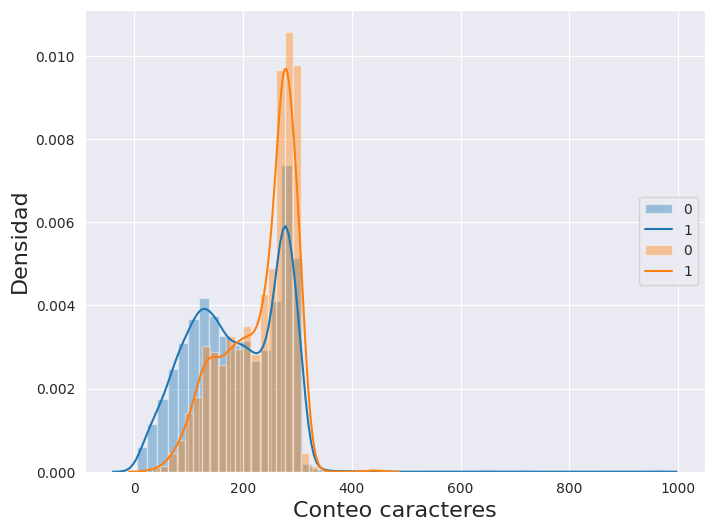

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.set_style("darkgrid")

plt1 = sns.distplot(dataset[dataset["label"]==0].char_len, hist=True, label="0")
plt2 = sns.distplot(dataset[dataset["label"]==1].char_len, hist=True, label="1")
plt.legend(labels=['0',"1",'0',"1"], loc = 5)

# Definimos el título de los ejes
plt.xlabel('Conteo caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

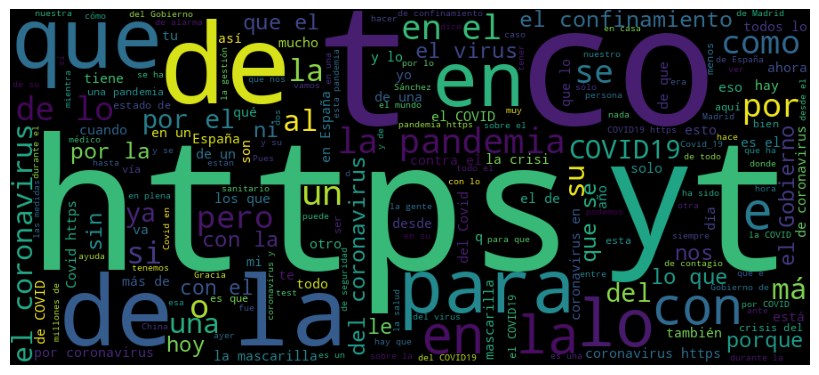

In [ ]:
# wordcloud
all_tweets = ' '.join(dataset['tweet_text'])
wordcloud = WordCloud(width=900, height=400, background_color='black', min_font_size=10).generate(all_tweets)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Nota: esta wordcloud no es muy informativa, ya que la estamos creando a partir de los tweets sin
# depurar, y por tanto la mayoría de las palabras má frecs son stopwords que carecen de significado.
# Más adelante, haremos otra wordcloud tras depurar los datos

## 3. Preprocesado y Normalización

En primer lugar, eliminaremos tweets duplicados, y los dobles espacios, si los hubiera

Después, extraeremos los emojis de los tweets, los guardaremos en una nueva columna del dataframe, y calcularemos un valor de sentimiento de emojis de positividad, negatividad y neutralidad.

Finalmente, pasaremos al preprocesado de los tweets:
* Primero quitaremos los emojis, pues ya tendremos los scores de sentimiento (y los emojis a nivel semántico no aportan info)
* Aplicaremos el objeto nlp para aplicar el modelo de preprocesado de spacy. Luego tendremos que guardar los datos que nos interesen con el formato adeacuado. Iremos paso a paso:
        - Tokenizar
        - Quitar stop words
        - Quitar puntuación
        - Pasar todo a minúscula
        - Lematizar

## Pasos previos

In [ ]:
# eliminar duplicados
total_tweets = len(dataset)
dataset = dataset.drop_duplicates(subset=['tweet_text'])
print("Se han eliminado {} tweets duplicados".format(total_tweets - len(dataset)))

Se han eliminado 0 tweets duplicados


In [ ]:
# eliminar los dobles espacios
print(dataset['tweet_text'][0]) # vemos que hay algunos dobles espacios

# Nota: mantendremos la col orig intacta
# (La col 'tweet_nlp' es en la que borraré los emojis y luego aplicaré el objeto nlp de spacy)
dataset['tweet_nlp'] = [tweet.replace("  "," ") for tweet in dataset['tweet_text']]

print(dataset['tweet_nlp'][0]) # comprobar corrección

CHINA: libera una pandemia EE.UU: libera OVNIS ARGENTINA: libera presos  Jajajajajajaja
CHINA: libera una pandemia EE.UU: libera OVNIS ARGENTINA: libera presos Jajajajajajaja


## Análisis del sentimiento de los emojis

In [ ]:
# Emojis
# (Tip: esta celda es copy-paste del Collab 6 "TwitterClassification" de clase)

# Función para preparar el diccionario de emojis
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis de un tipo entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

# Función para extraer emojis del texto en formato lista
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

# Calcula el sentimiento de los emojis de una lista utilizando el diccionario
# de emoji sentiment score generado previamente con la función load_emoji_sentiment().
# Se puede extraer el valor de positividad de los emojis con la option "positive"
# Se puede extraer el valor de neutralidad de los emojis con la option "neutral""  
# Se puede extraer el valor de negatividad de los emojis con la option "negative""  

def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e: 
      continue
  return output

# Eliminar los emojis de un texto. Esto es útil porque una vez extraido los emojis
# puede interesarnos tener un texto sin presencia de emojis para mejor análisis.
def clean_emoji(text):
    # Poner todos los comandos de http://www.unicode.org/Public/emoji/1.0/emoji-data.txt
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2

In [ ]:
# Cargamos un diccionario de emojis y sus sentimientos asociados
emoji_sent_dict = load_emoji_sentiment("Emoji_Sentiment_Data_v1.0.csv")

In [ ]:
# Extraemos los emojis
dataset["emoji_list"] = dataset["tweet_text"].apply(lambda x: extract_emojis(x))
dataset["emoji_list"]

0        []
1        []
2        []
3        []
4        []
       ... 
7995     []
7996     []
7997     []
7998    [🤮]
7999    [🤣]
Name: emoji_list, Length: 8000, dtype: object

In [ ]:
#Calcular los scores de sentimientos (posit, neutro y negat) de los tweets
dataset["sent_emoji_pos"] = dataset["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "positive"))
dataset["sent_emoji_neu"] = dataset["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "neutral"))
dataset["sent_emoji_neg"] = dataset["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "negative"))

# Nota: si no hay emojis, los scores serán cero

dataset[["sent_emoji_pos","sent_emoji_neu","sent_emoji_neg"]].describe()

,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg
count,8000.000000,8000.000000,8000.000000
mean,0.116440,0.100675,0.034885
std,0.327388,0.286236,0.123778
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,2.968292,2.748881,1.687731


## Preprocesado con spacy

Nota: también podríamos hacerlo con NLTK, tal y como está hecho en los notebooks de clase Collab 3 y 6.
Pero he optado por usar spacy para familiarizarme con su uso.

In [ ]:
# Quitar los emojis de los tweets
dataset["tweet_nlp"] = dataset["tweet_nlp"].apply(lambda x: clean_emoji(x))

In [ ]:
# Cargamos el modelo de spacy
nlp = spacy.load('es_core_news_lg')

Este modelo incluye el siguiente preprocesado:
  - Tokenización
  - Lematización
  - Eliminación de stopwords
  - Segmentación de oraciones
  - Etiquetado gramatical: etiquetas POS (part-of-speech) a cada token
  - Reconocimiento de entidades Nombradas (NER), como personas, lugares, organizaciones...
  - Análisis de dependencias: analizar las relaciones sintácticas entre los tokens en una oración

Vamos a aplicar este preprocesado a nuestro corpus, y a realizar una serie de comandos para
entender lo que estamos haciendo y para analizar un poco más nuestros datos

Nota: he decidido utilizar el modelo lg por ser el más completo

In [ ]:
# Aplicamos el nlp a nuestro corpus

# fomar 1:
dataset['tweet_nlp'] = dataset['tweet_nlp'].apply(nlp)
# Lo aplicamos sobre la col que creamos antes de cara a utilizarla precisamente ahora

## forma 2:
# dataset['tweet_nlp'] = [nlp(tweet) for tweet in dataset['tweet_nlp']]

In [ ]:
# Comprobación
print(type(dataset['tweet_nlp'][0])) # ahora tiene atributos que podemos utilizar/consultar (tokens, frases, ners...)
dataset['tweet_nlp'][0]

<class 'spacy.tokens.doc.Doc'>


CHINA: libera una pandemia EE.UU: libera OVNIS ARGENTINA: libera presos Jajajajajajaja

Si bien el objeto nlp ha transformado la columna 'tweet_nlp', y toda la información preprocesada que necesitamos para la vectorización (TF-IDF) ya está disponible, tenemos que seleccionarla y guardarla en el formato adecuado.

## Herramientas adicionales (sección extra)

Antes de pasar a analizar y completar el preprocesado, vamos a explorar algunas de las herramientas de análisis que ofrece spacy, como por ej:

- Part-of-speech (POS) tags: indican la función gramatical de cada palabra en una oración (por ejemplo, sustantivo, verbo, adjetivo, etc.).
- Named entity recognition (NER): identifica y clasifica entidades nombradas en el texto, como nombres de personas, lugares y organizaciones.
- Sentiment analysis: determina el tono emocional del texto, generalmente clasificándolo como positivo o negativo.

In [ ]:
# n-gramas
# Calculamos los bigramas, trigramas y 4 gramas del tweet 1
print("Bigramas: ", list(textacy.extract.ngrams(dataset['tweet_nlp'][0], 2, min_freq=1, filter_stops = False, filter_punct =False)))
print("Trigramas: ", list(textacy.extract.ngrams(dataset['tweet_nlp'][0], 3, min_freq=1, filter_stops = False, filter_punct =False)))
print("4-gramas: ", list(textacy.extract.ngrams(dataset['tweet_nlp'][0], 4, min_freq=1, filter_stops = False, filter_punct =False)))

# nota: los args de textacy.extract.ngrams() pueden ser útiles

Bigramas:  [CHINA:, : libera, libera una, una pandemia, pandemia EE.UU, EE.UU:, : libera, libera OVNIS, OVNIS ARGENTINA, ARGENTINA:, : libera, libera presos, presos Jajajajajajaja]
Trigramas:  [CHINA: libera, : libera una, libera una pandemia, una pandemia EE.UU, pandemia EE.UU:, EE.UU: libera, : libera OVNIS, libera OVNIS ARGENTINA, OVNIS ARGENTINA:, ARGENTINA: libera, : libera presos, libera presos Jajajajajajaja]
4-gramas:  [CHINA: libera una, : libera una pandemia, libera una pandemia EE.UU, una pandemia EE.UU:, pandemia EE.UU: libera, EE.UU: libera OVNIS, : libera OVNIS ARGENTINA, libera OVNIS ARGENTINA:, OVNIS ARGENTINA: libera, ARGENTINA: libera presos, : libera presos Jajajajajajaja]


In [ ]:
# Oraciones:
# Segmentamos los tweets en oraciones. Seguramente, tengan muy pocas

for num,sentence in enumerate(dataset['tweet_nlp'][3].sents):
    print('La oración número {} es: \n {}'.format(num, sentence))

# nota: enumerate itera una lista y devuelve cada elemento tupleado con su índice

La oración número 0 es: 
 El nuevo „covid normas y reglas recibimiento“ en el comercio minorista español.
La oración número 1 es: 
 Pateando desde @mkdirecto un día mas las calles y tiendas de Madrid para conocer y mostrar la nueva „consumo normalidad“: https://t.co/EPrZ9Ncb5m


In [ ]:
num_oraciones_por_documento = []

for doc in dataset['tweet_nlp']:
  num_oraciones = len(list(doc.sents))
  num_oraciones_por_documento.append(num_oraciones)

print(f'la media de frases de nuestro corpus es {np.mean(num_oraciones_por_documento)}')
print(f'la desv std es {round(np.std(num_oraciones_por_documento),3)}')

la media de frases de nuestro corpus es 2.393875
la desv std es 1.378


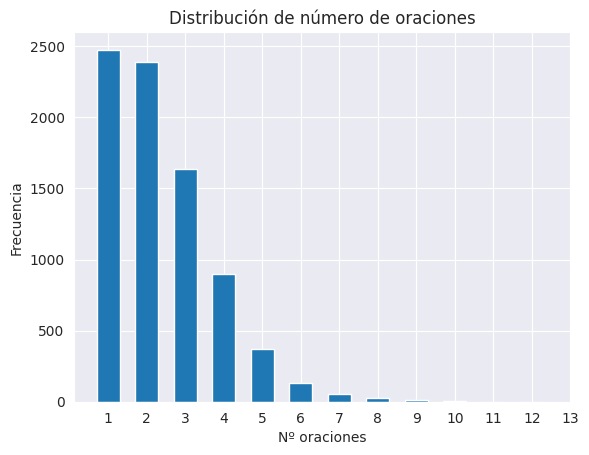

In [ ]:
# visualizar
intervalos = range(min(num_oraciones_por_documento), max(num_oraciones_por_documento) + 2) # para que se vea bien el hist
plt.hist(x=num_oraciones_por_documento, bins=intervalos, align='left', rwidth=0.6)

plt.xticks(intervalos)
plt.xlabel('Nº oraciones')
plt.ylabel('Frecuencia')
plt.title('Distribución de número de oraciones')

plt.show()

In [ ]:
# Part-of-Speech tagging (POS) - clases gramaticales

# recordemos que:
SPACY_POS_LIST = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ",
                  "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", 
                  "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X", "SPACE"]

unknown_index = [1,5,7,12,14,15,17] # consulto los que desconozco
[(SPACY_POS_LIST[i] ,spacy.explain(SPACY_POS_LIST[i])) for i in unknown_index]

[('ADP', 'adposition'),
 ('CCONJ', 'coordinating conjunction'),
 ('INTJ', 'interjection'),
 ('PROPN', 'proper noun'),
 ('SCONJ', 'subordinating conjunction'),
 ('SYM', 'symbol'),
 ('X', 'other')]

In [ ]:
lista_palabras = []
lista_clase_gramatical = []

for doc in dataset['tweet_nlp']:
  for word in doc:
    lista_palabras.append(word)
    lista_clase_gramatical.append(word.pos_)

# algunos ejemplos
for i in range(len(dataset['tweet_nlp'][0])):
  print(f'"{lista_palabras[i]}" es de clase "{lista_clase_gramatical[i]}"')

# Más adelante, cuando hayamos depurado mejor los tweets, contaremos la frecuencia de las POS 

"CHINA" es de clase "NOUN"
":" es de clase "PUNCT"
"libera" es de clase "VERB"
"una" es de clase "DET"
"pandemia" es de clase "ADJ"
"EE.UU" es de clase "PROPN"
":" es de clase "PUNCT"
"libera" es de clase "VERB"
"OVNIS" es de clase "PROPN"
"ARGENTINA" es de clase "PROPN"
":" es de clase "PUNCT"
"libera" es de clase "VERB"
"presos" es de clase "NOUN"
"Jajajajajajaja" es de clase "PROPN"


In [ ]:
# Reconocimiento de Entidades Nombradas (NER)
for i in range(5):
  print([(x.text, x.label_) for x in dataset['tweet_nlp'][i].ents])
# solo vamos a probarlo, así que vale con usarlo con los tweets originales (falla un poco pero bueno)

# Visualizar con displacy
displacy.render(dataset['tweet_nlp'][1], jupyter=True, style='ent') # 'ent' entidades

[('CHINA', 'LOC'), ('EE.UU', 'LOC'), ('OVNIS ARGENTINA', 'LOC'), ('Jajajajajajaja', 'ORG')]
[('San Francisco', 'LOC'), ('EEUU', 'LOC')]
[('Porfi', 'PER'), ('Rozalén', 'PER')]
[('Pateando desde @mkdirecto un día', 'MISC'), ('Madrid', 'LOC')]
[('Miguel Bosé', 'PER')]


In [ ]:
# Análisis de dependencias:
displacy.render(dataset['tweet_nlp'][0], jupyter=True, style='dep') # jupyter=True para que muestre la imagen, 'dep' dependencias

## Preprocesado

In [ ]:
# Tokenizar (ya está hecho, vamos a visualizarlo)

for num,tweet in enumerate(dataset['tweet_nlp'][0:3]): # enumerate y num simplemente para extraer el orden de los tweets
  print(f'Tokens del tweet {num}:')
  tokens = []
  for token in tweet:
    tokens.append(token.text) # atributo .text
  print(tokens)
  print("")

Tokens del tweet 0:
['CHINA', ':', 'libera', 'una', 'pandemia', 'EE.UU', ':', 'libera', 'OVNIS', 'ARGENTINA', ':', 'libera', 'presos', 'Jajajajajajaja']

Tokens del tweet 1:
['San', 'Francisco', '(', 'EEUU', ')', 'hace', '100', 'años', 'tras', 'vivir', 'la', 'pandemia', 'de', '1918', '.', 'https://t.co/veOT7nkdi8']

Tokens del tweet 2:
['Porfi', 'poneos', 'la', 'mascarilla', 'o', 'tendremos', '28', 'nuevas', 'canciones', 'de', 'artistas', 'colaborando', 'con', 'Rozalén', '.']



Lematizar:
El preprocesado de nlp ya realiza esta lematización, a través del atributo .lemma_
Pero para luego introducirlo en la función TFIDF de vectorización, vamos a darle el formato necesario:
guardar las tokens ya lematizadas, y como objetos tipo list y no spacy.tokens.doc.Doc

Nota: vamos a lematizar en lugar de a hacer stemming por dos razones:
    - tenemos 8000 tweets o textos cortos, por lo que podemos permitirnos el esfuerzo computacional
      que implica lematizar (stemming es menos costoso), a cambio de obtener mejores resultados
    - el preprocesado de spacy no incluye stemming pero sí lematizing, así que es más cómodo porque ya está hecho


In [ ]:
# veamos un ejemplo
for word in dataset['tweet_nlp'][2]:
  print(word.text, "---->", word.lemma_) # atributo .lemma_

Porfi ----> porfi
poneos ----> poneos
la ----> el
mascarilla ----> mascarilla
o ----> o
tendremos ----> tener
28 ----> 28
nuevas ----> nuevo
canciones ----> canción
de ----> de
artistas ----> artista
colaborando ----> colaborar
con ----> con
Rozalén ----> Rozalén
. ----> .


Haremos lo mismo con todos los tweets para guardar su lematización, utilizando listas de comprensión.

Además, en el mismo paso aprovecharemos para eliminar stopwords, signos de puntuación y dobles espacios, y para pasar de letras mayúsc a minúsc.

Nota: todo esto también lo hace nlp; lo que haremos será sencillamente guardar los tweets con el formato de preprocesado que nos interesa.


In [ ]:
# Lematización, eliminación de stopwords, signos de puntuación, dobles espacios, y paso de letras mayúsc a minúsc

# Veamos primero un ejemplo con 1 tweet
example = dataset['tweet_nlp'][1]

# Crear una lista de tokens lematizadas que no son stopwords, ni signos de puntuación, y las pasa a minúsc con lower()
tokens_filtradas = [unidecode(token.lemma_.lower()) for token in example if not token.is_stop and not token.is_punct]   

# Comprobar
print("Tweet original:\n", example)
print("Texto sin stopwords:\n", " ".join(tokens_filtradas)) # para el print, unimos los tokens en una cadena de texto

Tweet original:
 San Francisco (EEUU) hace 100 años tras vivir la pandemia de 1918. https://t.co/veOT7nkdi8
Texto sin stopwords:
 san francisco eeuu 100 ano vivir pandemia 1918 https://t.co/veot7nkdi8


In [ ]:
## Nota: podemos ver la lista de stopwords y signos de punt que elimina el modelo:
# print(nlp.Defaults.stop_words)
# print(nlp.Defaults.punctuations) # (mmm no funciona... bueno, usaremos la lista de string.punctuation en la celda siguiente)

# Es importante comprobar, al menos, que son stopwords en el idioma correcto:
print(list(nlp.Defaults.stop_words)[0:10])

['por', 'sería', 'ahi', 'dado', 'haciendo', 'podrias', 'breve', 'puedo', 'son', 'tener']


In [ ]:
# Ahora ya sí, aplicamos a la lista de todos los tweets:

# nota: vamos a hacerlo como si quisiéramos usar listas de stopwords y/o punct diferentes a las que vienen
# por defecto en el modelo de spacy. Podríamos hacerlo de esta manera (Collab 6 de clase):

punctuations = string.punctuation
stop_words = spacy.lang.es.stop_words.STOP_WORDS
# nlp.Defaults.stop_words == stop_words # es la misma lista de stopwords que la anterior, la lista de spacy en español

# forma 1:
dataset['tweet_lematize'] = [[unidecode(token.lemma_.lower()) for token in tweet\
    if token.text not in stop_words and token.text not in punctuations] for tweet in dataset['tweet_nlp']]

# Nota: ahora no ponemos if token not in... sino token.text. Esto se debe a que antes definíamos la condición
# con token.is_stop que es un atributo de un objeto 'Token' de spacy; ahora, token debe ser un 'string' ya que stop_words 
# es un set de strings

# Nota: reescribimos la col tweet_lematize

# forma 2:
# dataset['tweet_lematize'] =\
#     [[unidecode(token.lemma_.lower()) for token in tweet\
#     if not token.is_stop and not token.is_punct] for tweet in dataset['tweet_nlp']]

In [ ]:
# Distribución de la longitud de los tweet en tokens (ya filtradas)
dataset["token_len"] = dataset["tweet_lematize"].apply(lambda x: len(x))

In [ ]:
# Checkpoint (comprobar que vamos bien)
print(type(dataset['tweet_nlp'][1])) # tipo spacy.docs
print(type(dataset['tweet_lematize'][1])) # tipo list
print(dataset['tweet_lematize'][2]) # comprobamos que se han eliminado: mayúsc, punct, tildes (Rozalén. ---> rozalen)
dataset.head(3)

<class 'spacy.tokens.doc.Doc'>
<class 'list'>
['porfi', 'poneos', 'mascarilla', 'tener', '28', 'cancion', 'artista', 'colaborar', 'rozalen']


,tweet_id,tweet_text,label,set,char_len,tweet_nlp,emoji_list,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg,tweet_lematize,token_len
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,87,"(CHINA, :, libera, una, pandemia, EE.UU, :, li...",[],0.0,0.0,0.0,"[china, liberar, pandemio, ee.uu, liberar, ovn...",10
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,90,"(San, Francisco, (, EEUU, ), hace, 100, años, ...",[],0.0,0.0,0.0,"[san, francisco, eeuu, 100, ano, vivir, pandem...",9
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,95,"(Porfi, poneos, la, mascarilla, o, tendremos, ...",[],0.0,0.0,0.0,"[porfi, poneos, mascarilla, tener, 28, cancion...",9


In [ ]:
# Normalizar links a páginas web (no aportan info semántica relevante)
# Los sustituimos por una token que no tenga relación con los otros términos del texto, por ej, 'link'

dataset['tweet_lematize'] = [[re.sub(r'http\S+', 'link', word) for word in tweet] for tweet in dataset['tweet_lematize']]

dataset['tweet_lematize'][1]

['san', 'francisco', 'eeuu', '100', 'ano', 'vivir', 'pandemia', '1918', 'link']

Como el token 'link' no aporta info semántica, vamos a eliminarla de todos los tweets, pero antes
añadiremos una col booleana de si un tweet tiene o no enlaces web. Sospecho que esta info no será relevante para 
nuestro problema de clasificación particular, pero podemos probarlo

In [ ]:
dataset['has_link'] = [1 if 'link' in tweet else 0 for tweet in dataset['tweet_lematize']]
# (cuidado con ejecutar este comando después de haber eliminado la token link de todos los tweets - celda siguiente)

dataset['has_link'].describe()

count    8000.00000
mean        0.57925
std         0.49371
min         0.00000
25%         0.00000
50%         1.00000
75%         1.00000
max         1.00000
Name: has_link, dtype: float64

In [ ]:
# eliminamos la token 'link'
print(dataset['tweet_lematize'][1])
dataset['tweet_lematize'] = [[token for token in tweet if token != 'link'] for tweet in dataset['tweet_lematize']]
dataset['tweet_lematize'][1] # comprobar

['san', 'francisco', 'eeuu', '100', 'ano', 'vivir', 'pandemia', '1918', 'link']


['san', 'francisco', 'eeuu', '100', 'ano', 'vivir', 'pandemia', '1918']

*Nota: por falta de tiempo, no se ha realizado un tratamiento específico para tratar más adecuadamente los hashtags (#) y las menciones (@). Pero queríamos mencionarlos para recordar que juegan un papel relevante en la info contenida en los tweets*

Ahora sí, podemos generar una wordcloud con los términos más relevantes de verdad:

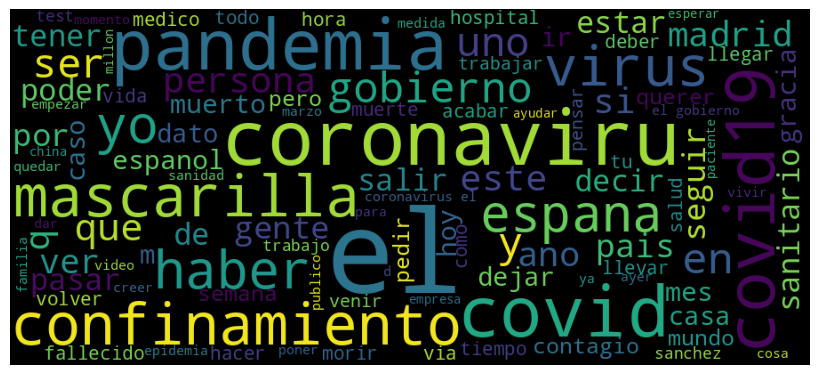

In [ ]:
# wordcloud

# unir todos los tweets en una única lista
all_words = sum(dataset['tweet_lematize'], [])

# convertir la lista a un único string
all_words_str = ' '.join(all_words)

# crear la wordcloud
wordcloud = WordCloud(width=900, height=400, background_color='black', min_font_size=10).generate(all_words_str)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# La cosa ha cambiado respecto a la anterior wordcloud. Ahora sí aparecen términos relevantes!

In [ ]:
# Finalmente, adaptamos el formato: unimos cada lista de palabras (cada tweet) en un solo string, separado por espacios
dataset['tweet_clean'] = [' '.join(tweet) for tweet in dataset['tweet_lematize']]
dataset.head()

,tweet_id,tweet_text,label,set,char_len,tweet_nlp,emoji_list,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg,tweet_lematize,token_len,has_link,tweet_lematize_POS,is_noun,is_ner,tweet_clean
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train,87,"(CHINA, :, libera, una, pandemia, EE.UU, :, li...",[],0.0,0.0,0.0,"[china, liberar, pandemio, ee.uu, liberar, ovn...",10,0,"[(china, NOUN), (liberar, VERB), (pandemio, AD...",1,1,china liberar pandemio ee.uu liberar ovnis arg...
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train,90,"(San, Francisco, (, EEUU, ), hace, 100, años, ...",[],0.0,0.0,0.0,"[san, francisco, eeuu, 100, ano, vivir, pandem...",9,1,"[(san, PROPN), (francisco, PROPN), (eeuu, PROP...",1,1,san francisco eeuu 100 ano vivir pandemia 1918
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train,95,"(Porfi, poneos, la, mascarilla, o, tendremos, ...",[],0.0,0.0,0.0,"[porfi, poneos, mascarilla, tener, 28, cancion...",9,0,"[(porfi, ADV), (poneos, VERB), (mascarilla, NO...",1,1,porfi poneos mascarilla tener 28 cancion artis...
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train,225,"(El, nuevo, „, covid, normas, y, reglas, recib...",[],0.0,0.0,0.0,"[el, ,,, covid, norma, regla, recibimiento, "",...",22,1,"[(covid, VERB), (norma, NOUN), (regla, NOUN), ...",1,1,"el ,, covid norma regla recibimiento "" comerci..."
4,1270421287148695556,Si el confinamiento ha dejado algo tocada tu e...,0,train,138,"(Si, el, confinamiento, ha, dejado, algo, toca...",[],0.0,0.0,0.0,"[si, confinamiento, dejar, tocado, estabilidad...",12,0,"[(confinamiento, NOUN), (dejar, VERB), (tocado...",1,1,si confinamiento dejar tocado estabilidad ment...


## POS tagging (sección extra)

In [ ]:
# Vamos a incluir la POS tag pero a los datos ya limpios:
dataset['tweet_lematize_POS'] =\
    [[(re.sub(r'http\S+', 'link', unidecode(token.lemma_.lower())), token.pos_) \
    for token in tweet if not token.is_stop and not token.is_punct] \
    for tweet in dataset['tweet_nlp']]

# creamos la dupla (token, POS) - hemos incluido pasos necesarios para hacerlo bien

In [ ]:
# cada tweet es una lista de duplas (token, POS)
print('tweet 1:')
for i in range(len(dataset['tweet_lematize_POS'][1])):
    print(f' token {i+1} --->', dataset['tweet_lematize_POS'][1][i])

tweet 1:
 token 1 ---> ('san', 'PROPN')
 token 2 ---> ('francisco', 'PROPN')
 token 3 ---> ('eeuu', 'PROPN')
 token 4 ---> ('100', 'NUM')
 token 5 ---> ('ano', 'NOUN')
 token 6 ---> ('vivir', 'VERB')
 token 7 ---> ('pandemia', 'NOUN')
 token 8 ---> ('1918', 'NOUN')
 token 9 ---> ('link', 'PROPN')


Nota: observar que nos separa 'san' y 'francisco' en lugar de identificarlo como una única entidad. Esto pasa porque hemos ignorado
las entidades al depurar los datos. Seguramene haya alguna forma más correcta de gestionar estos elementos (por falta de tiempo, no se han explorado alternativas). De cara a la posibilidad de que resulte información útil en nuestro problema de
clasificación, lo que podríamos hacer es construir una col booleana de si hay presente entidades (NER) de cierto tipo
por ej, instituciones o geolocalizaciones (tampoco lo he incluido por falta de tiempo).

In [ ]:
print('tweet 3:')
for i in range(len(dataset['tweet_lematize_POS'][2])):
    token = dataset['tweet_lematize_POS'][2][i][0] # ejemplo de cómo acceder a los elems de estas tuplas
    POS = dataset['tweet_lematize_POS'][2][i][1]
    print(f'"{token}" ---> "{POS}"')

tweet 3:
"porfi" ---> "ADV"
"poneos" ---> "VERB"
"mascarilla" ---> "NOUN"
"tener" ---> "VERB"
"28" ---> "NUM"
"cancion" ---> "NOUN"
"artista" ---> "NOUN"
"colaborar" ---> "VERB"
"rozalen" ---> "PROPN"


In [ ]:
# lista con listas de strings (POS) por tweet
lista_POS_tweet = [[dupla[1] for dupla in tweet] for tweet in dataset['tweet_lematize_POS']]

# lista de strings, sin mantener la distinción de tweets
lista_POS_total = [dupla[1] for tweet in dataset['tweet_lematize_POS'] for dupla in tweet]

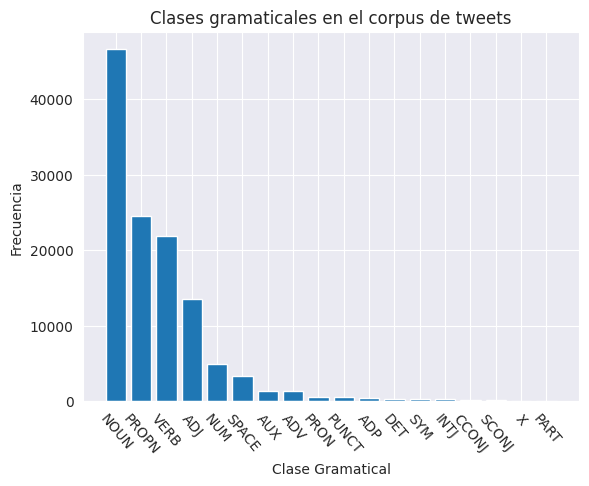

In [ ]:
# Contar las frecuencias de las clases gramaticales
frecuencias = Counter(lista_POS_total)

# Ordenar las frecuencias en orden descendente
frecuencias_ordenadas = dict(sorted(frecuencias.items(), key=lambda item: item[1], reverse=True))

# sorted recibe 2 args: la lista a ordenar, y la función que se usa para indicar/consultar el criterio de ordenación.
# En este caso, se toma como criterio el segundo elemento de la lista de tuplas 'frecuencias.items()', pues es la frecuencia de cada clase gramatical. 
# finalmente, se pasa de list a dict para recuperar el formato (keys,values) y así plotearlos fácilmente

# Visualizar
plt.bar(frecuencias_ordenadas.keys(), frecuencias_ordenadas.values())

plt.xlabel('Clase Gramatical')
plt.ylabel('Frecuencia')
plt.title('Clases gramaticales en el corpus de tweets')
plt.xticks(fontsize=10, rotation=310)  # ajustar tamaño de fuente de las etiquetas del eje x

plt.show()

In [ ]:
sorted(frecuencias.items(), key=lambda x: x[1], reverse=True)

[('NOUN', 46581),
 ('PROPN', 24490),
 ('VERB', 21896),
 ('ADJ', 13512),
 ('NUM', 4894),
 ('SPACE', 3361),
 ('AUX', 1415),
 ('ADV', 1311),
 ('PRON', 615),
 ('PUNCT', 608),
 ('ADP', 440),
 ('DET', 357),
 ('SYM', 327),
 ('INTJ', 310),
 ('CCONJ', 173),
 ('SCONJ', 170),
 ('X', 46),
 ('PART', 9)]

## Características adicionales

Ya habíamos obtenido el sentimiento de los emojis. Ahora, añadiremos algunas caracts adic más:
- presencia de tokens con cierta POS tag
- presencia de NER
- sentimiento del texto (no confundir con sentimiento de los emojis)

In [ ]:
# Meter col booleana de si un tweet tiene tokens de la clase 'NOUN' o no (ya que las profesiones suelen aparecer como sustantivos)

# También podríamos meter mil otras caracts adicionales, por ej, si tiene emojis o no (pero como ejemplo, así está bien)

dataset['is_noun'] = [1 if "NOUN" in [dupla[1] for dupla in tweet] else 0 for tweet in dataset['tweet_lematize_POS']]
dataset['is_noun'].describe()

count    8000.000000
mean        0.982875
std         0.129745
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: is_noun, dtype: float64

Como sale que casi todos los tweets tienen sustantivos, finalmente no añadiré esta col booleana como caract adicional,
ya que difícilmente aportará información útil para la predicción. Usaremos otro ejemplo como col booleana.

In [ ]:
# Añadir una col booleana de si el tweet contiene al menos 1 NER:

dataset['is_ner'] = [0 if tweet.ents == () else 1 for tweet in dataset['tweet_nlp']]
dataset['is_ner'].describe()

count    8000.000000
mean        0.866125
std         0.340539
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: is_ner, dtype: float64

**Análisis de sentimiento del texto**

In [ ]:
# Diccionario de sentimiento en castellano
# (Esta celda es copy-paste del script que nos pasaste para sentimiento en castellano)

# Descargamos un Spanish Emotion Lexicon
url_path = "https://www.cic.ipn.mx/~sidorov/SEL.txt"
sel_lexicon = pd.read_csv(url_path,sep="\t", encoding="latin-1")

# Para simplificarlo a 2 sentimientos, las categorías 'Alegría' y 'Sorpresa' se mapean a "positive", y el resto a "negative"
dicc_mapping = {"Alegría":"positive",
                "Sorpresa":"positive",
                "Tristeza":"negative",
                "Enojo":"negative",
                "Miedo":"negative",
                "Repulsión":"negative"}
                
sel_lexicon["Categoría"] = sel_lexicon["Categoría"].map(dicc_mapping)

# Guardamos ambos lexicons
positive_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="positive"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="positive"][' PFA']))
negative_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="negative"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="negative"][' PFA']))

# Definimos la función que utiliza ambos lexicons para extraer el score de sentimiento de una frase (string)
def calculate_sentiment(frase, positive_words, negative_words):
  """
  Función para calcular el score de sentimiento de una frase

  Args:
    frase [str]: Frase pre-preprocesada en español. Debe venir lematizada.
    positive_words [dict]: Diccionario de palabras positivas extraidas de SEL
    negative_words [dict]: Diccionario de palabras negativas extraídas de SEL

  Out:
    Sentiment score  
  """
  score = 0
  for i in frase.split():
    if i in positive_words:
      score = score + float(positive_words[i])
    elif i in negative_words:
      score = score - float(negative_words[i])
    else:
      score = score + 0
  
  return score

In [ ]:
# la col tweet_clean ya tiene el fmto str adecuado para aplicar la función anterior:
dataset['tweet_sentiment'] = [calculate_sentiment(tweet, positive_words, negative_words) for tweet in dataset['tweet_clean']]
dataset['tweet_sentiment'].head()

0    0.000
1    0.630
2    0.000
3    0.000
4    0.727
Name: tweet_sentiment, dtype: float64

In [ ]:
# Estas son las caracts adicionales que hemos decidido incorporar:
extra_features = ['sent_emoji_pos','sent_emoji_neg','sent_emoji_neu','tweet_sentiment','has_link','token_len','is_ner']

# Por tanto, las cols que contienen las variabs predictoras, ya normalizadas (*), son:
predictive_features = ['tweet_clean'] + extra_features
predictive_features

['tweet_clean',
 'sent_emoji_pos',
 'sent_emoji_neg',
 'sent_emoji_neu',
 'tweet_sentiment',
 'has_link',
 'token_len',
 'is_ner']

## 3.b Train Test Split

*Nota: si el dataset original no incluyera la división en train y test, este paso de dividir en train y test podríamos hacerlo más tarde, después de la vectorización.*

Podríamos hacer el típido train_test_split:

    # y = dataset["label"].values.astype(np.float32)
    # X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=seed)
    # print(X_train.shape)
    # print(X_test.shape)

No obstante, los datos orig vienen ya etiquetados como "train" y "valid" en la col 'set' (75% y 25%)

- Dividiremos nuestro dataset en dos dfs: train_df y test_df
- Prepararemos (.fit_transform) nuestro vectorizador con los datos de train_df usando train_df, obtendremos nuestro "mejor" modelo
- Finalmente, para poder testear el modelo, vectorizaremos test_df (solo .transform)

In [ ]:
# variabs X, train y test:
train_df = dataset[predictive_features].loc[dataset['set']=="train"]
test_df = dataset[predictive_features].loc[dataset['set']=="valid"]

# Aprovechamos para definir también la variable objetivo (col "label"), train y test:
y_train = dataset['label'].loc[dataset['set']=="train"].values.astype(np.float32)
y_test = dataset['label'].loc[dataset['set']=="valid"].values.astype(np.float32)

# Comprobación
print("Train_data", train_df.shape, y_train.shape)
print("Test_data", test_df.shape, y_test.shape)

# Comprobamos la distribución de la clase minoritaria
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts))) # 6000 filas

unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts))) # 2000 filas

Train_data (6000, 8) (6000,)
Test_data (2000, 8) (2000,)
{0.0: 4607, 1.0: 1393}
{0.0: 1523, 1.0: 477}


In [ ]:
# Escalar las variables (solo las extra_features, ver nota abajo):

# Las extra_features ya están en una escala entre 0 y 1, excepto token_len. La normalizamos: 
scaler = MinMaxScaler()
train_df['token_len'] = scaler.fit_transform(train_df[['token_len']]) # (fit_transform solamente los datos train)
test_df['token_len'] = scaler.transform(test_df[['token_len']]) # (solo transform para los datos test, evitar data_leakage)

train_df['token_len'].describe()

count    6000.000000
mean        0.243617
std         0.107111
min         0.000000
25%         0.157143
50%         0.242857
75%         0.328571
max         1.000000
Name: token_len, dtype: float64

**Nota sobre normalización de las variabs (numéricas)**

Por lo general, es una buena idea escalar todas las características antes de introducirlas en un clasificador, para evitar que alguna de las características domine sobre las demás en el proceso de entrenamiento. Sin embargo, escalar las características Tfidf no es recomendable, ya que sus valores ya están normalizados en función de su frecuencia en el documento y en el corpus, y al re-escalarlas se podría perder parte de la buena representabilidad que ofrece este método.

## 4. Vectorización

Argumentos de TfidfVectorizer()

*   *min_df*: para ignorar los tokens que aparecen en menos del X % de los documentos (0.01 = 1%). Cuanto más pequeño, menos caracts tendremos (más restrictivo)
*   *max_features*: máximo número de caracts que devuelve la función (las más importantes ie repetidas)
*   *ngram_range*: para incluir n-gramas al cálculo de la matriz tfidf, así podrá haber caracts que correspondan a n-gramas
*   *norm*: Valores "l1" y "l2", por defecto "l2". Normaliza los valores entre 0 y 1.

*   *use_idf*: Habilita el uso del inverse-document frequency (parte IDF en TF-IDF) en la función, para calcular los pesos de los términos en los documentos. Por defecto es True.
*   *smooth_idf*: Suaviza los pesos de IDF sumando una unidad a cada frecuencia. Es importante para evitar divisiones por cero.

No los vamos a usar:
*   *tokenizer*: Utiliza un tokenizador específico. Se puede utilizar una de NLTK o de Spacy(computacionalmente menos eficiente).
*   *strip_accents*: Elimina los acentos en codificación ascii o unicode. Por defecto es None. Es preferible hacer una gestión de acentos previas.
*   *lowercase*: Transforma todos los caracteres a minúsculas antes de hacer la tokenización.
*   *stop_words*: Si se pone el valor "english" eliminara la lista de stop_words definida en scikit-learn. Se puede utilizar la lista de stopwords de otras librerías o definir unas propias.
*   *max_df*: Valor por defecto 1.  Ignora los tokens (o n-gramas) que aparecen en más del X % de documentos cuando es menor de 1. Si max_df es mayor que uno se ignorarán los términos que aparecen en más de X documentos.

In [ ]:
vectorizador = TfidfVectorizer(lowercase = False,
                               stop_words = None,
                               tokenizer = None,
                               min_df = 0.001,
                               ngram_range = (1,3),
                               max_features = 350,
                               use_idf = True,
                               smooth_idf = True,
                               norm = "l2")

# fit con los datos de train
tfidf_vect = vectorizador.fit(train_df['tweet_clean']) # ojo: solo con la variab de los tweets

## Comprobar cantidad de features
print(f"Hay {tfidf_vect.get_feature_names_out().size} características")

# transform a train y a test
vector_data_train = tfidf_vect.transform(train_df['tweet_clean'])
vector_data_test = tfidf_vect.transform(test_df['tweet_clean'])

Hay 350 características


- Tip profe: el número óptimo de características para representar los documentos del ejercicio está entre 350-400, así conseguireis un buen compromiso entre velocidad de entrenamiento y resultados.

Entiendo que podemos combinar ambos para obtener todas las caracts posible (min_df) pero con un límite forzado (max_features).


**Añadir las caracts adicionales**

In [ ]:
# Utilizamos la librería scipy (función sparse.hstack) para unir las características TFIDF (contenidas en 'vector_data') con
# las 'extra_features'. Esta unión nos generará una matriz X numérica que representa los datos de nuestro corpus

# Extraemos los valores (values) de las extra_features
X_train = sp.sparse.hstack((vector_data_train, train_df[extra_features].values), format='csr')
X_test = sp.sparse.hstack((vector_data_test, test_df[extra_features].values), format='csr')

## Ya tenemos, finalmente: X_train, X_test, y_train, y_test

# Extraemos el nombre de las caracteríticas (lo usaremos luego para ver la importancia de cada extra_feature)
X_columns = list(vectorizador.get_feature_names_out()) + train_df[extra_features].columns.tolist()
X_columns[0:10]

['10', '100', '11', '12', '14', '15', '19', '20', '2020', '24']

## Visualizar tokens más importantes (Extra) 

In [ ]:
# Funciones para visualizar los tokens más importantes de cada tweet, según la vectorización TF-IDF realizada

tfidf_feature_names = np.array(tfidf_vect.get_feature_names_out())

def get_top_vect_words(response, top_n=5, feature_name_array=tfidf_feature_names):
  # De la respuesta del vectorizador, cogemos los datos en bruto del array, los ordenamos
  # de mayor a menor y cogemos los índices de los top_n terminos. Que se seleccionarán del 
  # los nombres de las caracteristicas (tokens) del vectorizador.
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_name_array[response.indices[sorted_nzs]]

def show_doc_results(doc, top_n, i):
    responses_tfidf = tfidf_vect.transform([doc])
    tfidf = list(get_top_vect_words(responses_tfidf, top_n, tfidf_feature_names))
    print(f"Tweet {i}: Tokens con mayor TF-IDF: {tfidf}")

In [ ]:
for i in range(0, len(train_df['tweet_clean'][0:7])):
    show_doc_results(train_df['tweet_clean'][i], 10, i)

# Observar que aparecen bigramas, por ej 'covid', '19', y 'covid 19'

Tweet 0: Tokens con mayor TF-IDF: ['china']
Tweet 1: Tokens con mayor TF-IDF: ['100', 'eeuu', 'vivir', 'ano', 'pandemia']
Tweet 2: Tokens con mayor TF-IDF: ['tener', 'mascarilla']
Tweet 3: Tokens con mayor TF-IDF: ['normalidad', 'calle', 'espanol', 'madrid', 'covid', 'el']
Tweet 4: Tokens con mayor TF-IDF: ['pensar', 'quedar', 'tu', 'dejar', 'poder', 'si', 'confinamiento']
Tweet 5: Tokens con mayor TF-IDF: ['comunidad', 'decir', 'ver', 'espana', 'fallecido', 'muerto', 'no', 'coronavirus', 'el']
Tweet 6: Tokens con mayor TF-IDF: ['tocar', 'estudio', 'paciente', 'covid 19', '19', 'covid', 'coronavirus']


## 5. Entrenamiento y evaluación de modelos


Esta última sección ya la hemos practicado en la tarea de ML con Python, del profesor Eduardo (incluido SMOTE como técnica de tratamiento de datos desbalanceados), así que en general no entraré en detalles conceptuales y me limitaré a indicar los pasos :)

In [ ]:
# Fijamos la semilla para el resto del código
seed = 99

**Tratam datos desbalanceados --> imblearn (SMOTE)**

Importante aplicar SMOTE solo sobre train_data, ya que:
a) el test debe consistir solo en observaciones reales
b) si hago resampling sobre todos mis datos, como los datos están desbalanceados, 
lo más probable es que los nuevos datos generados para la clase minoritaria sean
demasiado similares (si no iguales) a los ya existentes; de tal modo que, cuando
luego dividamos en train y test, los datos para esa clase minoritaria en test son
muy similares a aquellos con los que se ha entrenado el modelo, lo cual es una
fuente de sobreajuste brutal aunque no se detecte al evaluar con el conjunto test


In [ ]:
sm = SMOTE(random_state=seed)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Observamos el resultado del rebalanceo:
np.array(np.unique(y_train_resampled, return_counts=True)).T

array([[0.000e+00, 4.607e+03],
       [1.000e+00, 4.607e+03]])

In [ ]:
# Definimos la función encargada de entrenar y evaluar los algoritmos, para estimar
# el algoritmo que mejor funciona con nuestros datos
def model_evaluation(models, score_technique, X, y):
      results = []
      names = []
      for name, model in models:
          # Generamos un Kfold
          KF = KFold(n_splits=10, shuffle=True, random_state=seed)

          # Hacemos cross_val
          cv_results = cross_val_score(
              estimator=model,
              X=X,
              y=y,
              cv=KF,
              scoring=score_technique
          )
          results.append(cv_results)
          names.append(name)
          
          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score_technique)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

# Función para representar los boxplot con los resultados de la cross_val
sns.set_style('darkgrid')
np.set_printoptions(precision=2)

def boxplots_algorithms(results, names):
    plt.figure(figsize=(8,4))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

Metric: roc_auc , KFold 
Logistic: 0.787840 (0.023274) 
Metric: roc_auc , KFold 
DecisionTree: 0.661533 (0.019787) 
Metric: roc_auc , KFold 
GaussianNB: 0.717877 (0.023990) 
Metric: roc_auc , KFold 
KNN: 0.574697 (0.027085) 
Metric: roc_auc , KFold 
RandomForest: 0.776462 (0.023243) 


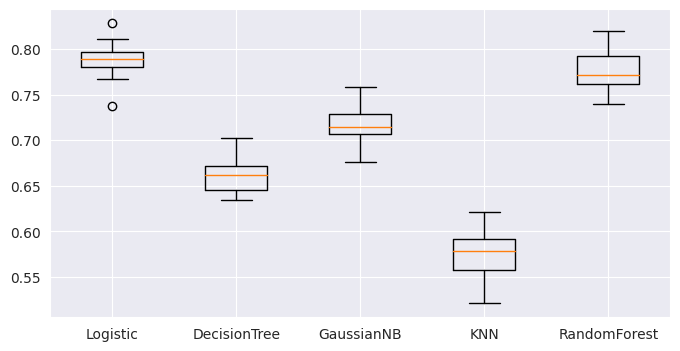

In [ ]:
# Modelos a probar
models = [
         ("Logistic",LogisticRegression(random_state=seed)),
         ("DecisionTree",DecisionTreeClassifier(random_state=seed)),
         ("GaussianNB",GaussianNB()),
         ('KNN', KNeighborsClassifier()),
         ('RandomForest', RandomForestClassifier(random_state=seed))
]

# Método de evaluación de bondad del modelo
evaluation_score = "roc_auc" # 'accuracy' también valdría, ya que los train_data son balanceados

# Realizar el entrenamiento de los modelos
results, names = model_evaluation(models,
                                  evaluation_score,
                                  X_train.toarray(),
                                  y_train)

# Resultados
boxplots_algorithms(results, names)

Aunque aparentemente logisticRegression es el mejor para nuestros datos, RandomForest es muy parecido, y como LogReg ya está hecho en el notebook del foro, he dedicido escoger RForest para practicar algo diferente :)

In [ ]:
# GridSearch para afinar los paráms del algoritmo de clasificacion escogido

# Modelo escogido
model = RandomForestClassifier(bootstrap=True,
                               min_samples_leaf=30, # estos paráms los fijamos así, para reducir el overfitting
                               random_state=seed)

# Malla de paráms (ejemplo de uso - se han probado diversas combinaciones)
parametros = {
    "n_estimators": [100,125,150], # número de árboles en el RForest
    "max_features": ['sqrt','log2'],
    "max_depth": [20,25,30],
    "criterion": ['gini','entropy'] # (no confundir con el criterio de scoring)
}

# Método de entrenamiento
cv_technique = KFold(n_splits=10, shuffle=True, random_state=seed)

# combinamos todo
gsearch = GridSearchCV(
    estimator=model,
    cv=cv_technique,
    param_grid=parametros,
    scoring='roc_auc' # 'accuracy' (*) 
)

# # (*) podemos ver todos los criterios ejecutando esto:
# from sklearn.metrics import get_scorer_names
# get_scorer_names()

# buscamos el mejor modelo
grid_model = gsearch.fit(X_train_resampled, y_train_resampled)

# resultados
print(grid_model.best_score_)
print(grid_model.best_estimator_)
print(grid_model.best_params_)

0.8803358115841865
RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=30,
                       random_state=99)
{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}


En la siguiente celda, he utilizado para el modelo de RForest los paráms que me devuelven un mejor resultado (aproximadamente) al testear con los datos de X_test e y_test.
Me he basado en los resultados del GridSearch, pero también he tenido que ajustar "manualmente" en base a los propios resultados finales con esos datos de test (**ver comentario en la celda final**).

In [143]:
# Entrenamos el modelo con los resultados ofrecidos por la grid_search

# Definir modelo y sus paráms
model = RandomForestClassifier(
    bootstrap=True,
    min_samples_leaf=30,
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    criterion='entropy',
    random_state=seed
)

# Entrenar modelo
RF_model = model.fit(X_train_resampled, y_train_resampled)

# Testear modelo
y_pred = RF_model.predict(X_test)

# Resultados
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1523
         1.0       0.58      0.46      0.51       477

    accuracy                           0.79      2000
   macro avg       0.71      0.68      0.69      2000
weighted avg       0.78      0.79      0.78      2000



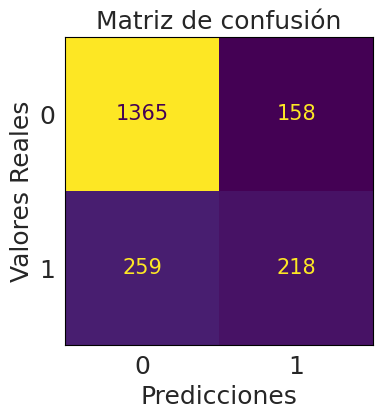

In [144]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='viridis', values_format='d', colorbar=False)
ax.grid(False) # Deshabilitar el grid de fondo

plt.title('Matriz de confusión', fontsize=18) # Cambiar tamaño del título
ax.spines[['bottom','top','left','right']].set_color('black')
plt.xlabel('Predicciones', fontsize=18)
plt.ylabel('Valores Reales', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for text in ax.texts:
    text.set_fontsize(15) # Cambiar tamaño de valores dentro de la matriz
plt.show()

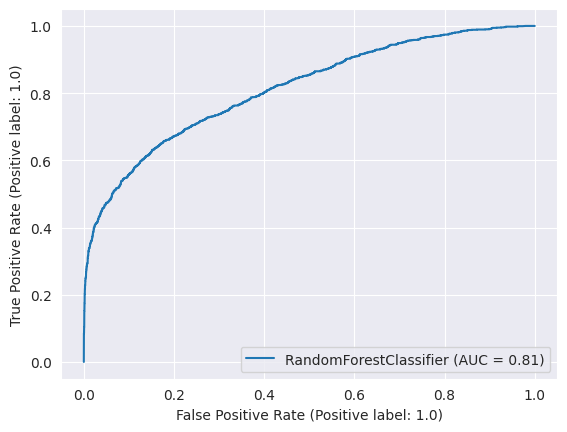

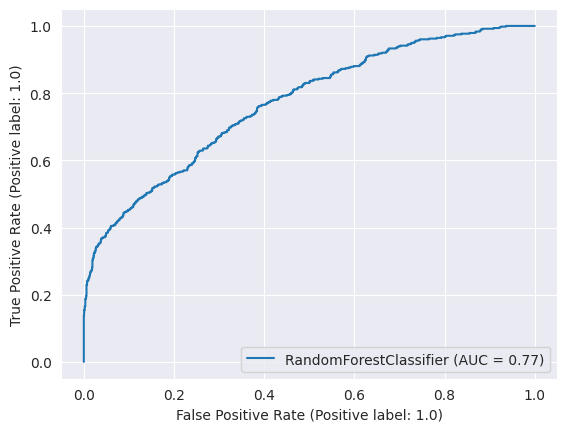

In [145]:
# Curva ROC
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(RF_model, X_train, y_train)
RocCurveDisplay.from_estimator(RF_model, X_test, y_test)

# Recordatorio: si las curvas ROC de train y test fuesen significativamente diferentes,
# el modelo probablemente estaría sobreajustando

# RocCurveDisplay es muy sencillo y directo de usar, pero tiene la desventaja de que no nos
# permite plotear las curvas ROC de train y test en la misma gráfica (lo haremos en la sig celda)

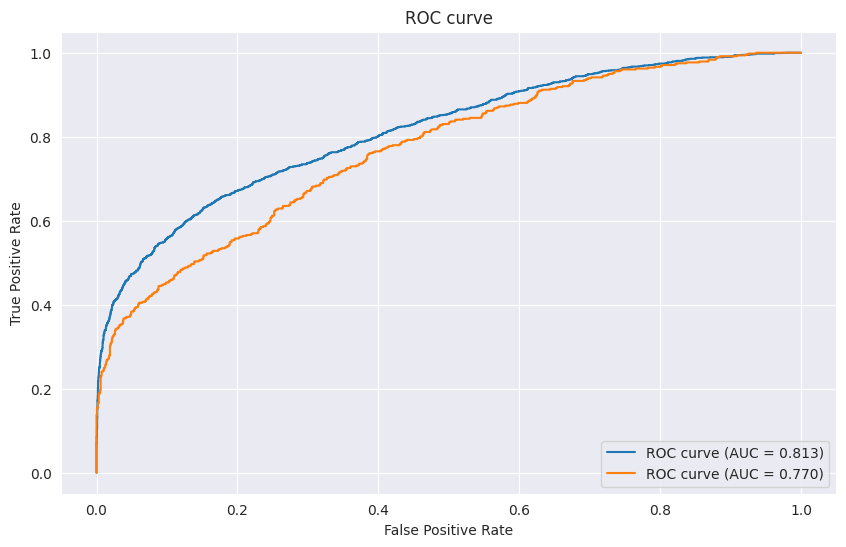

In [146]:
def generar_roc_curve(X, y, model):
    # Obtener la probabilidad de predicción para la clase positiva (1)
    y_score = model.predict_proba(X)[:, 1]

    # Calcular y plotear la curva ROC
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.3f)' % roc_auc)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

# Aplicar la función para plotear
plt.subplots(figsize=(10, 6))
generar_roc_curve(X_train, y_train, RF_model)
generar_roc_curve(X_test, y_test, RF_model)
plt.show()

Nuestro modelo final de clasificación de tweets en español para determinar si en el tweet se mencionan profesiones sanitarias (etiqueta 1) o no (etiqueta 0) está guardado en el objeto 'RF_model':

In [150]:
# Modelo final

RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 30,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 99,
 'verbose': 0,
 'warm_start': False}

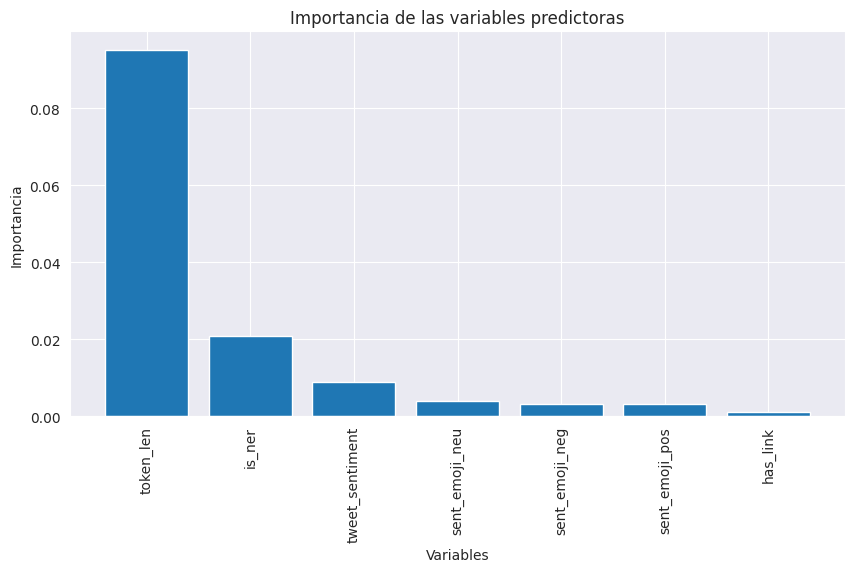

In [152]:
# Comprobar si las caracts adic son o no relevantes en nuestro modelo

# Obtener la importancia de las variables predictoras
importances = RF_model.feature_importances_

# Nombre de las variables predictoras
variables = X_columns # (las teníamos de antes)

# Crear un dataframe con la información
df_importances = pd.DataFrame({'Variable': variables, 'Importancia': importances})

# Ordenar las variables por su importancia
df_importances = df_importances.sort_values('Importancia', ascending=False)

# Seleccionar solo la extra_features
df_importances_extra_features = \
    df_importances.loc[df_importances['Variable'].isin(['sent_emoji_pos','sent_emoji_neg','sent_emoji_neu','tweet_sentiment','has_link','token_len','is_ner'])]

# Gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(df_importances_extra_features['Variable'], df_importances_extra_features['Importancia'])
plt.xticks(rotation=90)
plt.title('Importancia de las variables predictoras')
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.show()

Vemos, pues, que la única caracts adicional relevante es 'token_len', ie el número de tokens que tiene el tweet.

## Sobre el análisis con GridSearch

Nota:
Dejé corriendo la celda del GridSearch durante 3 horas para probar GridSearch con estos paráms:

    # parametros = {
    #     "n_estimators": [70,100,120,140], # número de árboles en el RForest
    #     "max_features": ['sqrt','log2'],
    #     "max_depth": [12,15,20,25,30,35,40,45,50],
    #     "min_samples_leaf": [10,20,30,40],
    #     "criterion": ['gini','entropy'] # (o confundir con el criterio de scoring)
    # }

El resultado fue:

- 0.896282557922033
- RandomForestClassifier(criterion='entropy', max_depth=45, min_samples_leaf=10, random_state=99)
- {'criterion': 'entropy', 'max_depth': 45, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}

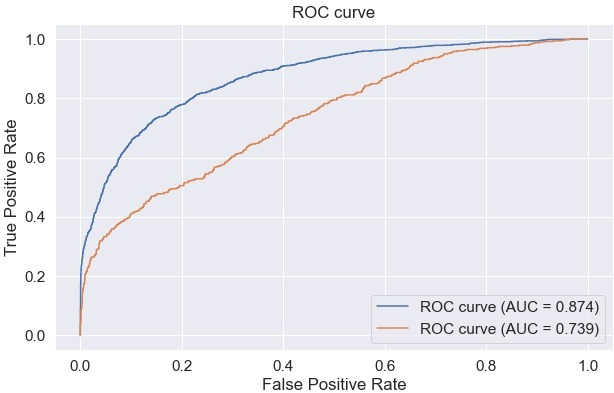

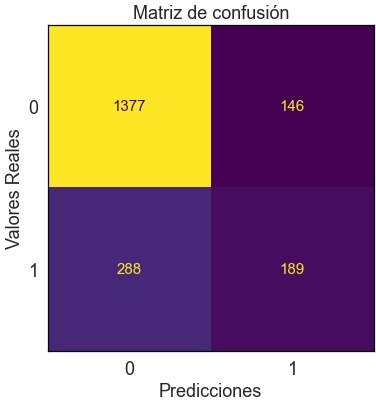

Si bien es cierto que el AUC de train es muy alto, vemos estos problemas:
* el modelo resultante es más complejo, tiene árboles mucho más ramificados
* hay mayor diferencia entre el AUC de train y test que con otros modelos (ie hay overfitting)
*el modelo falla más que otros modelos a la hora de predecir la clase minoritaria - se ve en la matriz de confusión (no estoy seguro de por qué ocurre esto)
* si bien con este modelo, el AUC de test es mayor que con otros modelos menos overfitteados,
hay que tener en cuenta que también puede importante la robustez del modelo; es decir, con un modelo más robusto 
puede que obtengamos valores algo menores de precisión, pero al menos tendremos menos variabilidad
en la precisión de los resultados, lo cual puede ser algo deseado.


## Comentario final (DUDA)

*(Duda planteada por email (lema.madrid@gmail.com), la copio aquí porque me parece que la tarea estaría incompleta sin este análisis)*

Se supone que, una vez elegido un algoritmo, por ej RandomForest, para determinar los mejores parámetros del mismo podemos usar GridSearch para hacer una malla de valores y probar múltiples modelos para compararlos y escoger el mejor. Se supone que en ese proceso, probamos los modelos con cross_validation (CV) para así puntuar cada modelo en base al scoring del fold “test” en cada ronda, y así sacar un promedio de ese scoring en los 10 folds del KFold (te estoy contando con el ejemplo de lo que he hecho yo por simplificar).

Se supone que las combinaciones de paráms que den modelos que se sobreajustan a los datos de los 9 folds de “train”, luego deberían dar un score peor con el fold “test” precisamente porque están sobreajustados. Y así, GridSearch nos ayudaría a encontrar el equilibrio entre modelo preciso y modelo no sobreajustado (bias-variance tradeoff).
 
Sin embargo, me he encontrado con que el GridSearch me escoge modelos con valores de scoring (he probado accuracy y roc_auc) muy altos (0.86 aprox; recuerdo que es el scoring promedio de los folds de “test” en la CV), pero que sin embargo luego, al probarlos con mi conjunto de TEST_REAL, dan resultados bastante peores (score 0.72 aprox).
Además, son modelos con árboles muy ramificados, muy complejos. En otras palabras, me está escogiendo modelos complejos y sobreajustados!!!
 
Y no entiendo por qué.
 
Solo se me ocurre que, de alguna forma que no termino de ver, el SMOTE está influyendo y provoca que por mucho que estemos haciendo cross_val, los datos que quedan cada vez en el fold (test) sean tan similares a los de los demás folds (train), y por eso la cross_val no penaliza el sobreajuste... porque no lo está detectando!
 
No sé si puede ser algo así tipo: la clase 0 tiene tweets muy diversos, y la clase 1 son pocos tweets, y smote hace otros muy similares. Entonces, el modelo aprende que ciertos tweets son 1, y todos los demás que no sean similares (aunque puedan ser muy distintos entre sí), los mete a 0.
Y por tanto, como las observaciones de la clase 1 son muy similares en el fold "test" y en los 9 folds de train, pues la cross_val los clasifica bien.
 
Pero luego, con los datos de TEST_REALES, los tweets de clase 1 ya no son tan similares (¿????) y entonces falla más.
 
Esta duda me preocupa por dos motivos:
 
1.	Me parece importante en sí
2.	Precisamente nuestro objetivo era detectar los tweets de la clase 1. De poco me sirve se bueno prediciendo la clase 0, si en la clase 1 tengo un resultado regular…

-----------------------------------------------

De hecho, otra duda importante y  que comparto con otros compañeros es:
 
Por qué el modelo final, al hacer el TEST_REAL, predice bien la clase 0 pero relativamente mal la clase 1?
Quiero decir, los datos de TEST estarán desbalanceados, pero los de train no (por smote), así que no lo entiendo (quizás tiene que ver lo que he dicho arriba? Y si no es el caso, cuál es el motivo?)

